In [1]:
from SL_C0de.grid import ICE_TIME_GRID
from SL_C0de.grid import SEDIMENT_TIME_GRID
from SL_C0de.grid import TOPOGRAPHIC_TIME_GRID
from SL_C0de.grid import OCEAN_TIME_GRID
from SL_C0de.love import LOVE
import numpy as np
import sys

np.set_printoptions(threshold=sys.maxsize)

maxdeg=64
stop=120 # define the number of time steps
step=1
time_step=np.arange(start=stop,stop=0,step=-step)

ice_time_grid=ICE_TIME_GRID(from_file=(True,'ice_grid_64'))
sed_time_grid=SEDIMENT_TIME_GRID(from_file=(True,'sed_grid_64'))
topo_time_grid=TOPOGRAPHIC_TIME_GRID(from_file=(True,'topo_grid_64'))


In [4]:
# Initiate the base elements
from SL_C0de.spharm import sphericalobject
from SL_C0de.Load import LOAD
load=LOAD(maxdeg,ice_time_grid.time_step)
topo_time_grid.update_0()
ocean_time_grid.evaluate_ocean(topo_time_grid.grd_0).grdtocoeff()
ocean_time_grid.update_0()
ocean_time_grid.save_prev()
ice_time_grid.sdeli_00=ice_time_grid.height_time_coeff[0,0] # peut être à passer dans l'initialisation ou le modify de ice object après leurs création
topo_time_grid.grid_from_step(0)
# grd correspond donc au topo_j défini dans le code de kendal et al.
ocean_time_grid.evaluate_ocean(topo_time_grid.grd).grdtocoeff()
TO=sphericalobject(grd=topo_time_grid.grd_0*(ocean_time_grid.grd-ocean_time_grid.grd_0)).grdtocoeff()
TO.prev=np.zeros(TO.coeff.shape)


In [3]:
for t_it in range (ice_time_grid.time_step_number):
    topo_time_grid.grid_from_step(t_it)
    # grd correspond donc au topo_j défini dans le code de kendal et al.
    ocean_time_grid.evaluate_ocean(topo_time_grid.grd).grdtocoeff()
    TO.grd=topo_time_grid.grd_0*(ocean_time_grid.grd-ocean_time_grid.grd_0)
    TO.grdtocoeff()
    sed_time_grid.coeff_from_step(t_it)
    ice_time_grid.coeff_from_step(t_it)
    ice_time_grid.sdeli_00=ice_time_grid.coeff[0]
    


    conv_lim=10**(-3)
    print(ice_time_grid.time_step[t_it])
    if t_it==0 : 
        conv_it=0
    else :
        conv_it=1
    ocean_time_grid.sea_level_solver(load,ice_time_grid,sed_time_grid,love_number,TO,t_it,conv_it,conv_lim)


    
    #print(ocean_time_grid.delPhi_g)

    ocean_time_grid.prev=ocean_time_grid.height_time_coeff[t_it,:].copy()
    # if t_it==0:
    #     print(ocean_time_grid.height_time_coeff[t_it,:])
    TO.prev=TO.coeff.copy()
    if t_it==0:
        ice_time_grid.deli_00_prev=ice_time_grid.height_time_coeff[0,0]
    else :
        ice_time_grid.deli_00_prev=ice_time_grid.height_time_coeff[:t_it,0].sum(0)
    

    topo_time_grid.height_time_grid[t_it,:,:]=topo_time_grid.height_time_grid[t_it,:,:]-(ocean_time_grid.delSLcurl.grd+ocean_time_grid.delPhi_g)

120.0
119.0
118.0
117.0
116.0
115.0
114.0
113.0
112.0
111.0
110.0
109.0
108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0


c:\Users\ahenry01\Desktop\Python_code\SL_C0de_lib_0_4_0\src\SL_C0de\grid.py:645: RuntimeWarning: divide by zero encountered in scalar divide
  chi = np.abs((np.sum(np.abs(RO.coeff + self.delPhi_g*self.coeff -  TO.coeff - self.height_time_coeff[0,:])) - np.sum(np.abs(self.height_time_coeff[t_it,:]))) / np.sum(np.abs(self.height_time_coeff[t_it,:])))
c:\Users\ahenry01\Desktop\Python_code\SL_C0de_lib_0_4_0\src\SL_C0de\grid.py:648: RuntimeWarning: divide by zero encountered in scalar divide
  chi = np.abs((np.sum(np.abs(RO.coeff + self.delPhi_g*self.coeff -  TO.coeff - self.height_time_coeff[:t_it,:].sum(0))) - np.sum(np.abs(self.height_time_coeff[t_it,:]))) / np.sum(np.abs(self.height_time_coeff[t_it,:])))


98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0


From here you can do two things. simply solving the sea level equation. Wich would be on one iteration. The sea level equation is a differential equation with the ocean load on two side of the equation. Therefor, we need to converge the code toward the solution by updating the ocean load on both side of the equation. First we will solve the sea level equation at one step. 

In [4]:
ocean_time_grid.timecoefftotimegrd()


C:\Users\ahenry01\AppData\Local\Temp\ipykernel_14620\3240253961.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('bwr', 100)


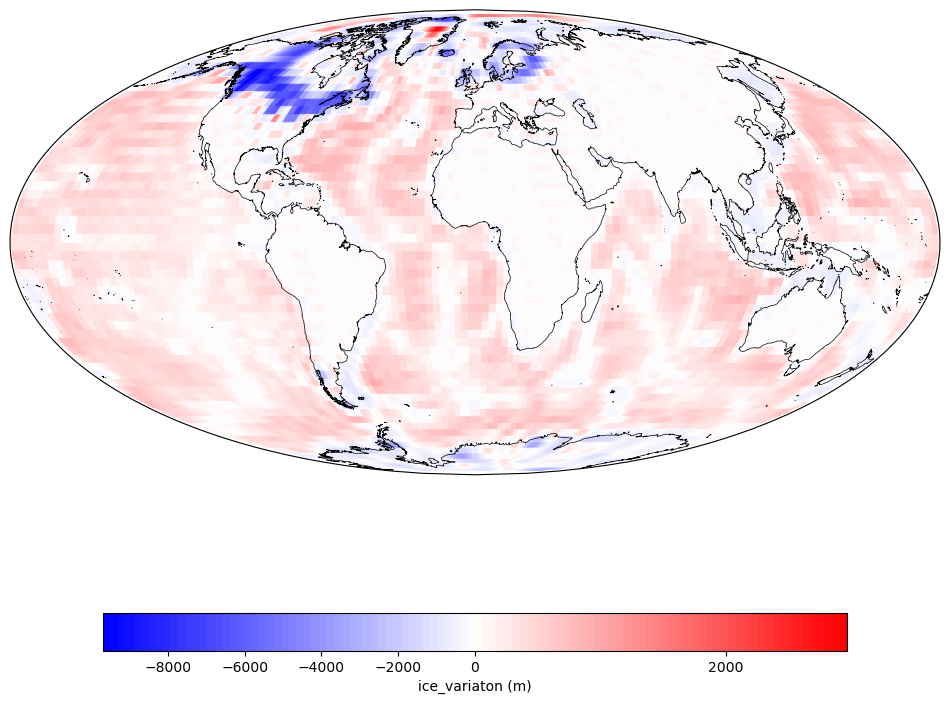

In [12]:
import cartopy
import cartopy.crs as ccrs
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

t_it=100

cmap=cm.get_cmap('bwr', 100)
alpha_ocean=0
coast_line_width=0.5

fig = plt.figure(figsize=(12, 12), facecolor="none")

norm = colors.TwoSlopeNorm(vmin=None,vmax=None,vcenter=0)
#norm = colors.TwoSlopeNorm(vmin=ocean_time_grid.height_time_grid[t_it,:,:].min(),vmax=ocean_time_grid.height_time_grid[t_it,:,:].max(),vcenter=0)
ax1  = plt.subplot(111, projection=ccrs.Mollweide())
ax1.set_global()
m2 = ax1.imshow(ocean_time_grid.height_time_grid[1:t_it,:,:].sum(0), origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=cmap, interpolation="gaussian",norm=norm)
cbar2=plt.colorbar(mappable=m2, orientation="horizontal", shrink=0.8)
cbar2.set_label('ice_variaton (m)')
#cbar2.set_ticks([ocean_time_grid.height_time_grid[t_it,:,:].min(), 0, ocean_time_grid.height_time_grid[t_it,:,:].max()])
ax1.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax1.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)

C:\Users\ahenry01\AppData\Local\Temp\ipykernel_14620\3261304932.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('bwr', 100)


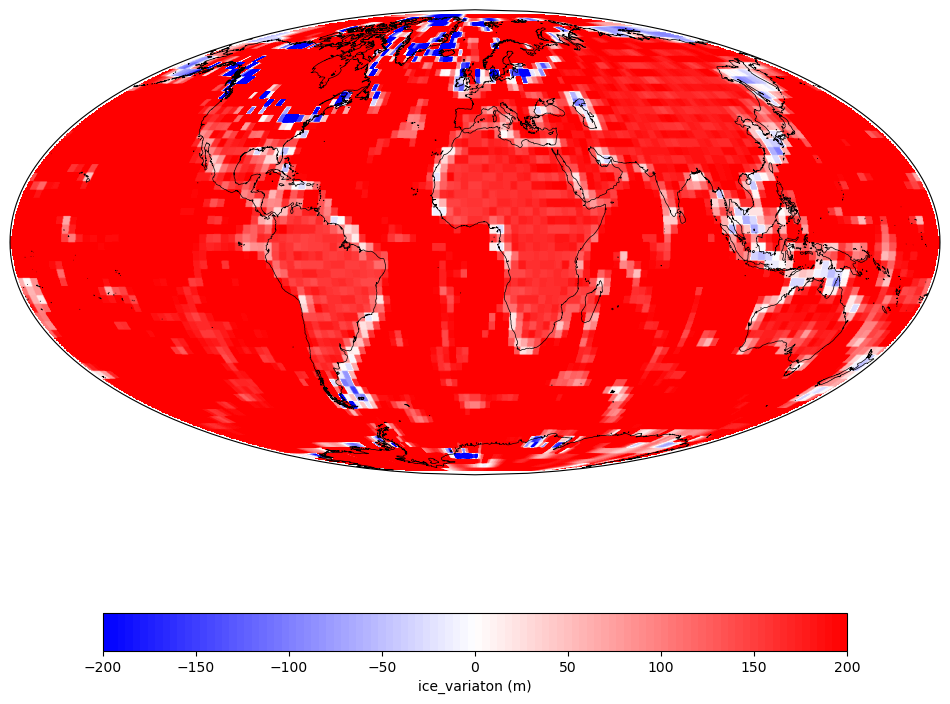

In [23]:
import cartopy
import cartopy.crs as ccrs
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

t_it=100

cmap=cm.get_cmap('bwr', 100)
alpha_ocean=0
coast_line_width=0.5

fig = plt.figure(figsize=(12, 12), facecolor="none")

norm = colors.TwoSlopeNorm(vmin=-200,vmax=200,vcenter=0)
#norm = colors.TwoSlopeNorm(vmin=ocean_time_grid.height_time_grid[t_it,:,:].min(),vmax=ocean_time_grid.height_time_grid[t_it,:,:].max(),vcenter=0)
ax1  = plt.subplot(111, projection=ccrs.Mollweide())
ax1.set_global()
m2 = ax1.imshow(topo_time_grid.height_time_grid[-1,:,:]-ice_time_grid.height_time_grid.sum(0)-sed_time_grid.height_time_grid.sum(0)-(topo_time_grid.height_time_grid[t_it,:,:]-ice_time_grid.height_time_grid[:t_it+1,:,:].sum(0)-sed_time_grid.height_time_grid[:t_it+1,:,:].sum(0)), origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=cmap, interpolation="gaussian",norm=norm)
cbar2=plt.colorbar(mappable=m2, orientation="horizontal", shrink=0.8)
cbar2.set_label('ice_variaton (m)')
#cbar2.set_ticks([ocean_time_grid.height_time_grid[t_it,:,:].min(), 0, ocean_time_grid.height_time_grid[t_it,:,:].max()])
ax1.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax1.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)

In [3]:
# Initiate the base elements
from SL_C0de.spharm import sphericalobject
from SL_C0de.Load import LOAD

topo_time_grid.topo_pres=topo_time_grid.height_time_grid[-1,:,:].copy()
ice_time_grid.ice=ice_time_grid.height_time_grid
ocean_time_grid=OCEAN_TIME_GRID(time_step,maxdeg,grid_name='ocean_grid')
ocean_time_grid.time_step_number=ocean_time_grid.time_step_number-1

ice_time_grid.timegrdtotimecoeff()
sed_time_grid.timegrdtotimecoeff()

love_number=LOVE(maxdeg,'C:/Users/ahenry01/Desktop/Python_code/SL_C0de_data/VM5a_122',time_step,6371000,5.9742e24)
TO=sphericalobject(coeff=np.zeros(ice_time_grid.height_time_coeff[0,:].shape))

load=LOAD(maxdeg,ice_time_grid.time_step)

topo_diff=np.inf
sdel_topo_diff=np.inf
topo_it=0
while topo_diff>10**(0) and sdel_topo_diff>10**(-1):
    delPhi_g_time=np.array([])
    TO.prev=np.zeros(ice_time_grid.height_time_coeff[0,:].shape)

    if topo_diff != np.inf :
        topo_time_grid.height_time_grid[0,:,:]=topo_initial.copy()
    # topo_time_grid.height_time_grid = topo_time_grid.height_time_grid - ice_time_grid.height_time_grid + ice_time_grid.ice # for resetting the corrected ice.
    ice_time_grid.ice_correction(topo_time_grid,ocean_time_grid)
    ice_time_grid.timegrdtotimecoeff()
    
    topo_time_grid.update_0()
    ocean_time_grid.evaluate_ocean(topo_time_grid.grd_0).grdtocoeff()
    ocean_time_grid.update_0()
    ocean_time_grid.save_prev()
    topo_time_grid.grid_from_step(0)
    # grd correspond donc au topo_j défini dans le code de kendal et al.
    ocean_time_grid.evaluate_ocean(topo_time_grid.grd).grdtocoeff()
    TO.grd=topo_time_grid.grd_0*(ocean_time_grid.grd-ocean_time_grid.grd_0)
    TO.grdtocoeff()

    track_conv=np.array([])

    for t_it in range (ice_time_grid.time_step_number):
        topo_time_grid.grid_from_step(t_it)
        # grd correspond donc au topo_j défini dans le code de kendal et al.
        ocean_time_grid.evaluate_ocean(topo_time_grid.grd).grdtocoeff()
        TO.grd=topo_time_grid.grd_0*(ocean_time_grid.grd-ocean_time_grid.grd_0)
        TO.grdtocoeff()
        sed_time_grid.coeff_from_step(t_it)
        ice_time_grid.coeff_from_step(t_it)
        


        conv_lim=10**(-10)
        #print(ice_time_grid.time_step[t_it])
        if topo_it==0 : 
            conv_it=0
        else :
            conv_it=1
        conv_it=ocean_time_grid.sea_level_solver(load,ice_time_grid,sed_time_grid,love_number,TO,t_it,conv_it,conv_lim)

        track_conv=np.append(track_conv,conv_it)     
        
        TO.prev=TO.coeff.copy()

        ocean_time_grid.save_prev()
        
        topo_time_grid.height_time_grid[t_it,:,:]=topo_time_grid.grd_0-(ocean_time_grid.delSLcurl.grd+ocean_time_grid.delPhi_g)

        delPhi_g_time=np.append(delPhi_g_time,ocean_time_grid.delPhi_g)

    topo_it+=1
    print(ocean_time_grid.height_time_coeff[:,0].sum())
    topo_pres_ice_corrected=topo_time_grid.topo_pres-ice_time_grid.ice.sum(0)+ice_time_grid.height_time_grid.sum(0)
    sdel_topo_diff=np.abs(topo_diff-np.abs(topo_time_grid.height_time_grid[-1,:,:]-topo_pres_ice_corrected).max().max())
    topo_diff=np.abs(topo_time_grid.height_time_grid[-1,:,:]-topo_pres_ice_corrected).max().max()
    print(topo_it,' : ',topo_diff, sdel_topo_diff,track_conv-(topo_it>0))
    topo_initial=topo_pres_ice_corrected - (topo_time_grid.height_time_grid[-1,:,:]-topo_time_grid.height_time_grid[0,:,:])

c:\Users\ahenry01\Desktop\Python_code\SL_C0de_lib_0_4_0\src\SL_C0de\grid.py:639: RuntimeWarning: divide by zero encountered in scalar divide
  chi = np.abs( (np.sum(np.abs(RO.coeff + self.delPhi_g*self.coeff -  TO.coeff)) - np.sum(np.abs(self.height_time_coeff[t_it,:]))) / np.sum(np.abs(self.height_time_coeff[t_it,:])))


(7.599914163707762+0j)
1  :  2643.8425 inf [10. 11. 10. 10. 11. 12. 11. 12. 13. 13. 13. 12. 12. 13. 12. 12.  9. 12.
 12. 11. 12. 12. 12. 12. 13. 13. 12. 11. 12. 12. 12. 13. 12. 12. 13. 11.
 11. 13. 11. 12. 12. 12. 13. 12. 12. 11. 12. 11. 12. 12. 13. 13. 13. 13.
 14. 13. 12. 11. 14. 13. 11. 13. 14. 13. 13. 13. 12. 13. 13. 14. 12. 13.
 12. 12. 12. 13. 13. 13. 13. 14. 14. 12. 13. 13. 12. 13. 12. 12. 12. 12.
 12. 13. 13. 13. 12. 13. 14. 13. 12. 13. 12. 13. 12. 11. 12. 12. 10. 11.
 11. 11. 10. 10. 10. 11. 13. 14. 14. 13. 13.]
(2.2173700916125476+0j)
2  :  1217.7957 1426.0469 [10. 13. 11. 12. 11. 11. 11. 11. 10. 12. 11. 12. 11. 11. 10. 12. 11. 10.
 12. 10. 13. 11. 10. 12. 11. 11. 11. 11. 11. 11. 12. 11. 11. 11. 11. 12.
 11. 11. 11. 11. 11. 12. 11. 12. 11. 13. 12. 13. 14. 12. 11. 11. 12. 12.
 10. 11. 12. 14. 13. 12. 14.  9. 12. 12. 10. 11. 13. 12. 11. 11. 12. 12.
 11. 10. 11. 11. 10. 10. 11. 11. 12. 12. 11. 10. 10. 10. 12. 11. 12. 14.
 11. 10. 12. 11. 12. 10. 11. 12. 12. 11. 11. 12. 12. 13. 1

In [14]:
ESL=ice_time_grid.height_time_coeff[:,0]/ocean_time_grid.evaluate_ocean(topo_time_grid.topo_pres).grdtocoeff().coeff[0]*(ice_time_grid.rho/ocean_time_grid.rho)

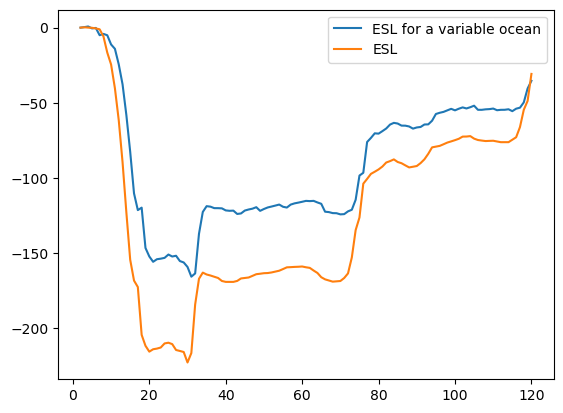

In [24]:
import matplotlib.pyplot as plt
plt.plot(ocean_time_grid.time_step[:-1],delPhi_g_time*9.81-delPhi_g_time[-1]*9.81,label='ESL for a variable ocean')
plt.plot(ocean_time_grid.time_step[:-1],ESL[::-1].cumsum()[::-1]*9.81,label='ESL')
plt.legend()

In [4]:
ocean_time_grid.timecoefftotimegrd()

C:\Users\ahenry01\AppData\Local\Temp\ipykernel_18580\1856527275.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('bwr', 100)


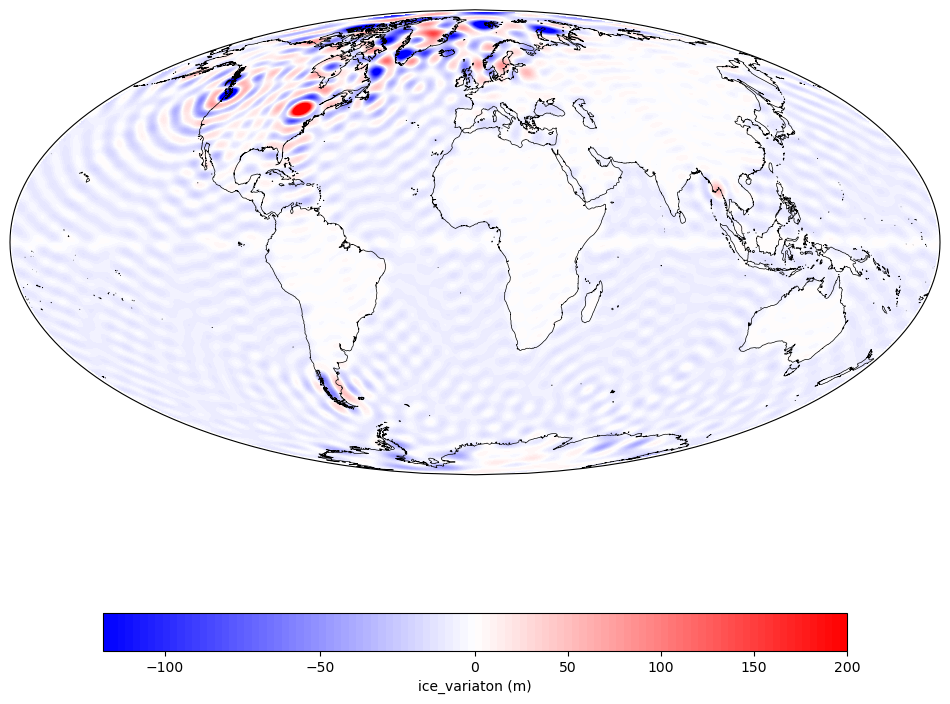

In [24]:
import cartopy
import cartopy.crs as ccrs
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

t_it=10
ocean_time_grid.coeff=ocean_time_grid.height_time_coeff[t_it:,:].sum(0).squeeze()
grid=-ocean_time_grid.coefftogrdhd(1024)
cmap=cm.get_cmap('bwr', 100)
alpha_ocean=0
coast_line_width=0.5

fig = plt.figure(figsize=(12, 12), facecolor="none")

norm = colors.TwoSlopeNorm(vmin=-120,vmax=200,vcenter=0)
#norm = colors.TwoSlopeNorm(vmin=ocean_time_grid.height_time_grid[t_it,:,:].min(),vmax=ocean_time_grid.height_time_grid[t_it,:,:].max(),vcenter=0)
ax1  = plt.subplot(111, projection=ccrs.Mollweide())
ax1.set_global()
m2 = ax1.imshow(grid, origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=cmap, interpolation="gaussian",norm=norm)
cbar2=plt.colorbar(mappable=m2, orientation="horizontal", shrink=0.8)
cbar2.set_label('ice_variaton (m)')
#cbar2.set_ticks([ocean_time_grid.height_time_grid[t_it,:,:].min(), 0, ocean_time_grid.height_time_grid[t_it,:,:].max()])
ax1.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax1.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)